### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

### Load dataset

In [5]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path('../src/disease_dataset')

### Get image count

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2982


### Seperate data to classes

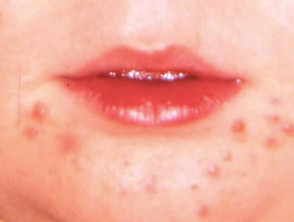

In [7]:
acne = list(data_dir.glob('Acne/*'))
PIL.Image.open(str(acne[0]))

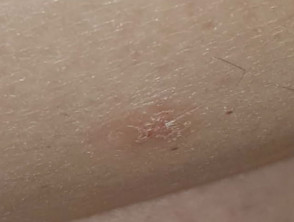

In [8]:
cyst = list(data_dir.glob('Cyst, tumour and skin-tags/*'))
PIL.Image.open(str(cyst[0]))

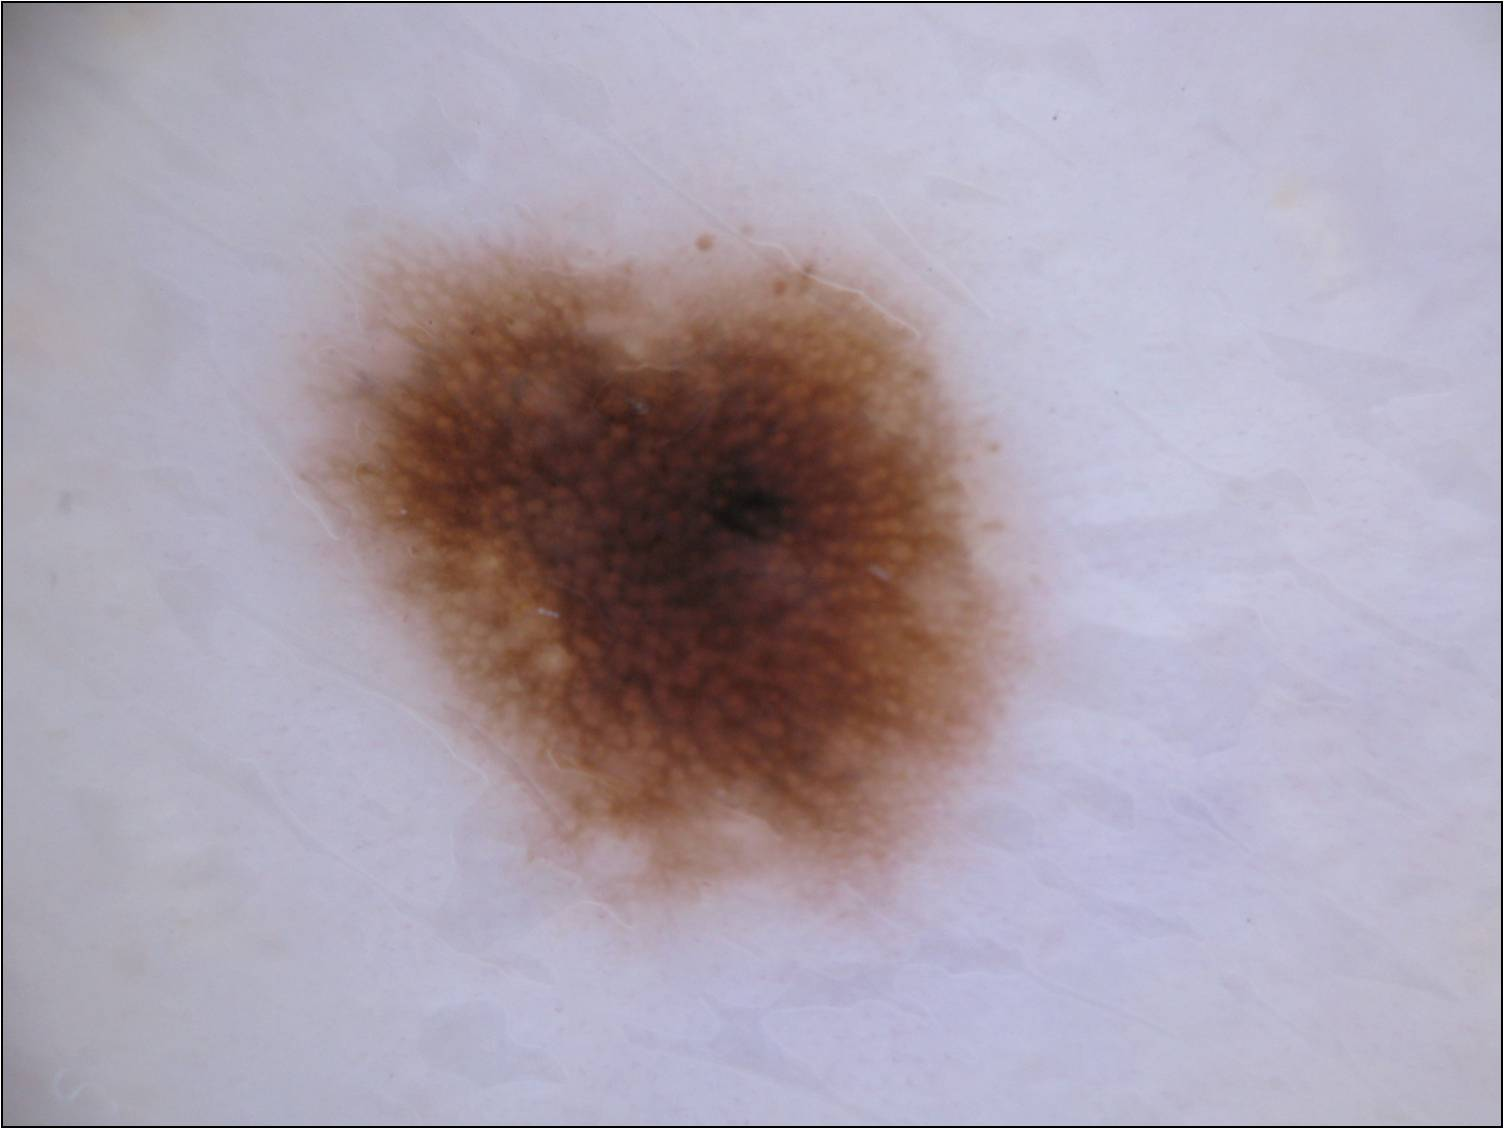

In [10]:
melanoma = list(data_dir.glob('Melanoma/*'))
PIL.Image.open(str(melanoma[0]))

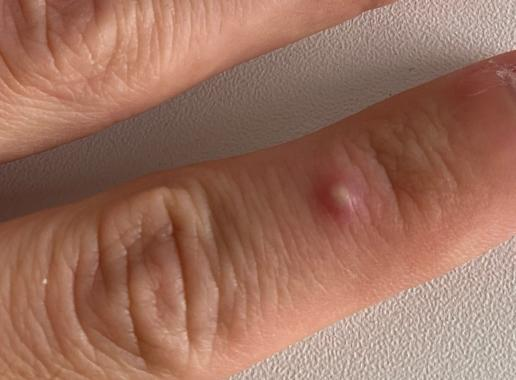

In [11]:
monkeypox = list(data_dir.glob('Moneypox/*'))
PIL.Image.open(str(monkeypox[0]))

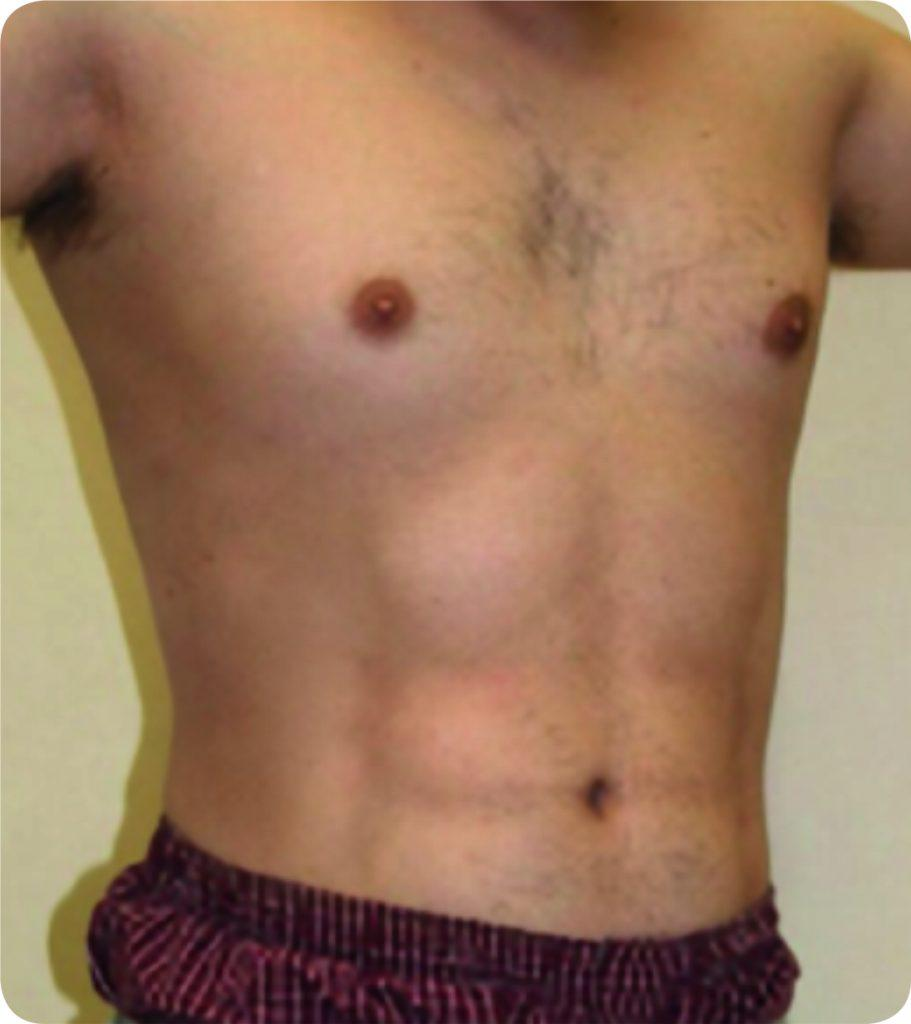

In [12]:
skin = list(data_dir.glob('Normal skin/*'))
PIL.Image.open(str(skin[0]))

### Define a scale

In [13]:
batch_size = 32
img_height = 180
img_width = 180

### Training dataset

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2985 files belonging to 5 classes.
Using 2388 files for training.


### Validation dataset

In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2985 files belonging to 5 classes.
Using 597 files for validation.


### Class names

In [16]:
class_names = train_ds.class_names
print(class_names)

['Acne', 'Cyst, tumour and skin-tags', 'Melanoma', 'Moneypox', 'Normal skin']


### First 9 images of training dataset

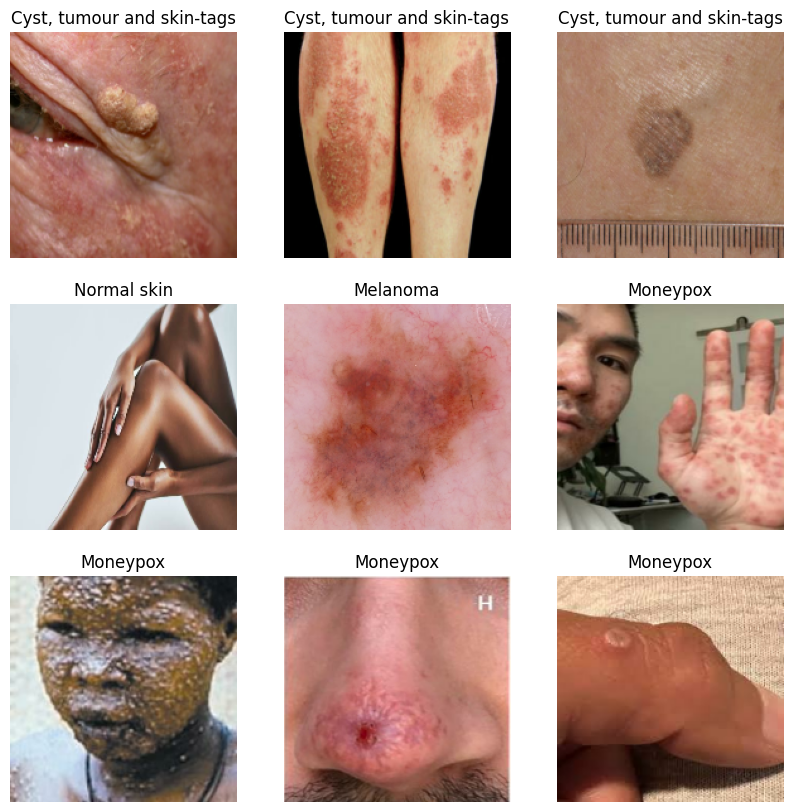

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Retrieve batches of images

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.numpy().shape)
  print(labels_batch.numpy().shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [21]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.93278116


### Create the model

In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 58s 719ms/step - loss: 1.4601 - accuracy: 0.4012 - val_loss: 1.0946 - val_accuracy: 0.5176
Epoch 2/10
75/75 [==============================] - 44s 591ms/step - loss: 1.0770 - accuracy: 0.5415 - val_loss: 1.2004 - val_accuracy: 0.5092
Epoch 3/10
75/75 [==============================] - 40s 535ms/step - loss: 0.9673 - accuracy: 0.6097 - val_loss: 0.9682 - val_accuracy: 0.5812
Epoch 4/10
75/75 [==============================] - 39s 522ms/step - loss: 0.8258 - accuracy: 0.6725 - val_loss: 0.9385 - val_accuracy: 0.6198
Epoch 5/10
75/75 [==============================] - 38s 503ms/step - loss: 0.7057 - accuracy: 0.7211 - val_loss: 0.9966 - val_accuracy: 0.6097
Epoch 6/10
75/75 [==============================] - 38s 512ms/step - loss: 0.6224 - accuracy: 0.7605 - val_loss: 1.0203 - val_accuracy: 0.6097
Epoch 7/10
75/75 [==============================] - 38s 511ms/step - loss: 0.5537 - accuracy: 0.7839 - val_loss: 1.0678 - val_accuracy: 0.6265

### Visualize training results

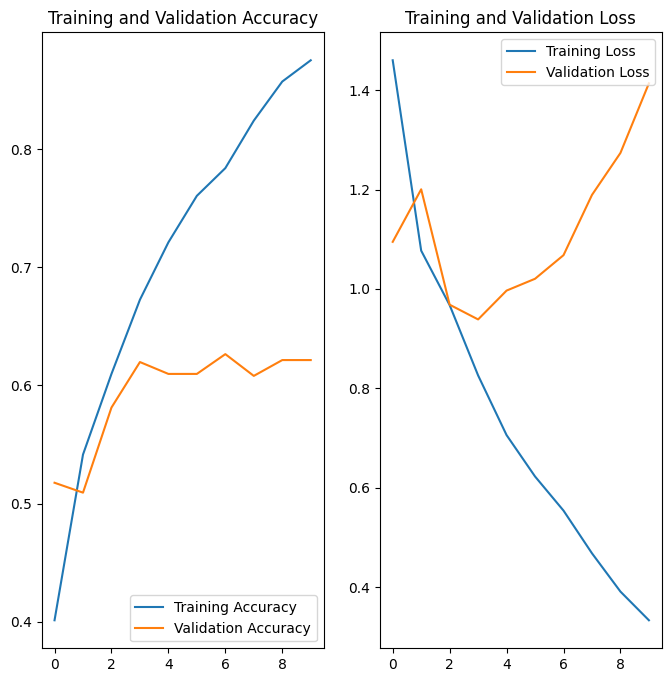

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data augmentation

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### Visualize augmented examples

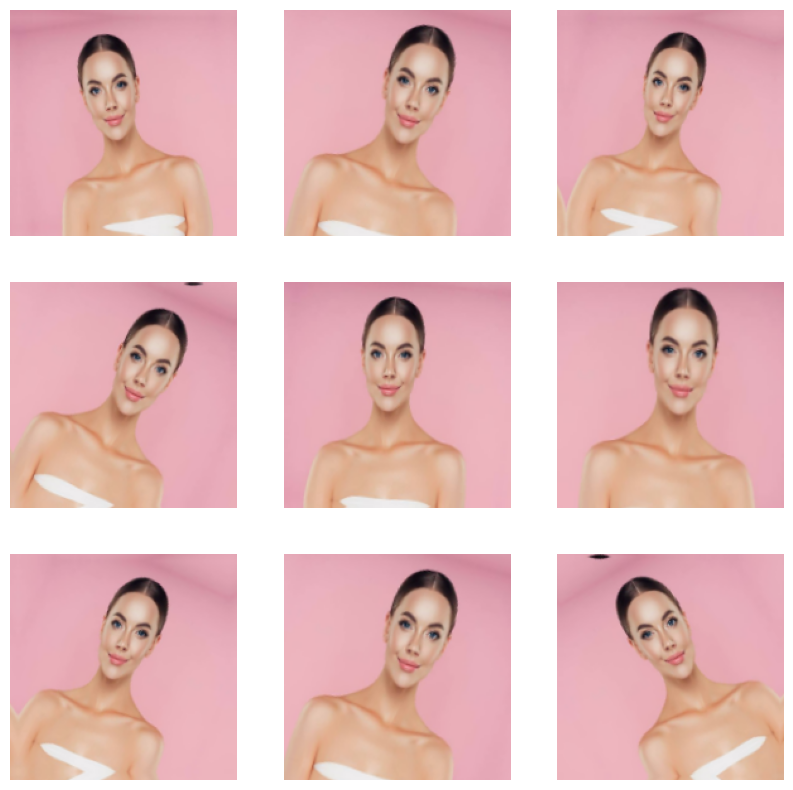

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and train the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [33]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
75/75 [==============================] - 65s 790ms/step - loss: 1.4060 - accuracy: 0.3647 - val_loss: 1.2294 - val_accuracy: 0.4523
Epoch 2/15
75/75 [==============================] - 48s 646ms/step - loss: 1.1300 - accuracy: 0.5243 - val_loss: 1.1233 - val_accuracy: 0.5075
Epoch 3/15
75/75 [==============================] - 52s 699ms/step - loss: 1.0606 - accuracy: 0.5662 - val_loss: 1.0515 - val_accuracy: 0.5628
Epoch 4/15
75/75 [==============================] - 61s 810ms/step - loss: 0.9981 - accuracy: 0.5863 - val_loss: 1.0304 - val_accuracy: 0.5829
Epoch 5/15
75/75 [==============================] - 59s 788ms/step - loss: 0.9371 - accuracy: 0.6101 - val_loss: 1.0194 - val_accuracy: 0.5946
Epoch 6/15
75/75 [==============================] - 60s 804ms/step - loss: 0.8860 - accuracy: 0.6369 - val_loss: 1.0018 - val_accuracy: 0.5695
Epoch 7/15
75/75 [==============================] - 54s 717ms/step - loss: 0.8854 - accuracy: 0.6428 - val_loss: 1.1037 - val_accuracy: 0.5879

### Visualize training results

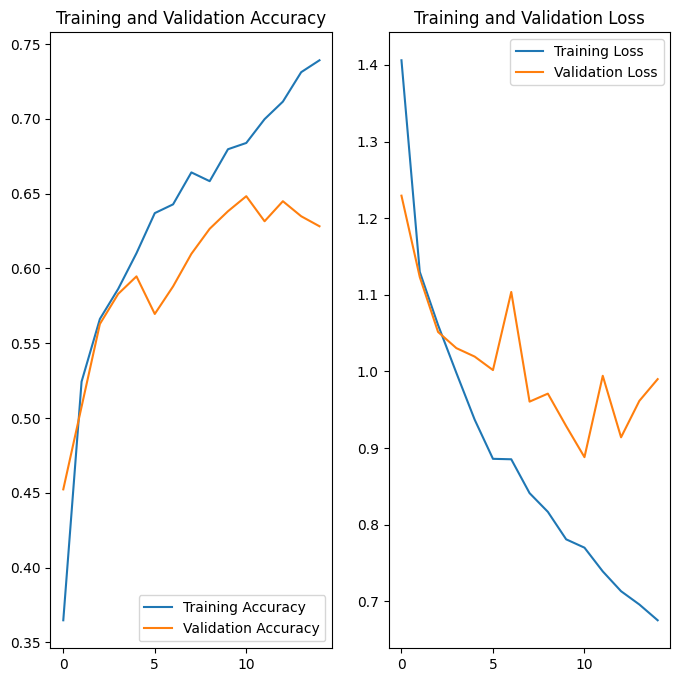

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [37]:
img = tf.keras.utils.load_img(
    '../src/images/Monkeypox_2.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Normal skin with a 94.14 percent confidence.
